In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.layers import Dense,Input,Lambda,Concatenate
from keras.models import Model
from keras.losses import categorical_crossentropy
import keras.backend as K
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

from scipy.stats import norm
from sklearn.manifold import Isomap

/home/elijahc/.pyenv/versions/3.5.2/envs/jupyterlab/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from src.utils import process_mnist,gen_trajectory,gen_sorted_isomap
from src.models import build_dense

In [3]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_shape=(784,)
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


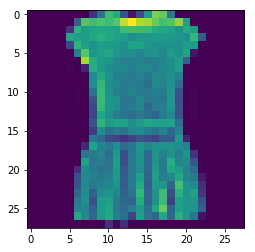

In [4]:
plt.imshow(x_train[3].reshape(28,28))

In [5]:
encoding_dim = 64
latent_dim = 2
y_dim = 2
inputs = Input(shape=input_shape)

# Brian Cheungs netowkr
encoded = build_dense(inputs,[500,500],activations='relu')

# encoded = build_dense(inputs,[512,encoding_dim],activations='relu')

In [6]:
z_mean = Dense(latent_dim)(encoded)
# z_log_sigma = Dense(latent_dim)(encoded)

def sampler(args):
    mean,log_stddev = args
    std_norm = K.random_normal(shape=(K.shape(mean)[0],latent_dim),mean=0,stddev=1)
    
    return mean + K.exp(log_stddev) * std_norm

# lat_vec = Lambda(sampler)([z_mean,z_log_sigma])

In [7]:
# y_hat_mean = Dense(y_dim,name='y_mean')(encoded)
# y_hat_sigma = Dense(y_dim,name='y_sigma')(encoded)
# y_hat = Lambda(sampler, name='y_hat')([y_hat_mean,y_hat_sigma])
y_hat = Dense(10,name='y_hat',activation='softmax')(encoded)

# Concatenate with One-hot identity vector
combo_vec = Concatenate()([z_mean,y_hat])

decoded_mean = build_dense(combo_vec,[500,500,784],activations=['relu','relu','linear'])
# decoded_mean = build_dense(combo_vec,[encoding_dim,512,784],activations=['relu','relu','sigmoid'])

In [17]:
from src.losses import *
from keras.metrics import categorical_accuracy

def acc(y_true,y_pred):
    return categorical_accuracy(y_true,y_hat)

def kl_loss_tot(y_true,y_pred):
    return kl_loss_z(y_true,y_pred)

def xentropy(y_true,y_pred):
    return 2*categorical_crossentropy(y_true,y_hat)

def recon_mse(y_true,y_pred):
    return K.mean(K.sum(K.square(y_pred-inputs),axis=-1),axis=0)

In [18]:
recon_loss = ReconstructionLoss(inputs=inputs,outputs=decoded_mean)
xcov = XCov(y_hat,z_mean,weight=1)
# kl_loss_z = KLDivergenceLoss(z_log_sigma,z_mean,weight=0.001,name='DKL_z')

In [19]:
vae = Model(inputs,decoded_mean)
def vae_loss(y_true,y_pred):
    total_loss = 0
    loss_fns = [
        K.sum(recon_loss(y_true,y_pred)),
        10*xcov(y_true,y_pred),
        K.sum(10*categorical_crossentropy(y_true,y_hat)),
#         K.sum(kl_loss_z(y_true,y_pred))/128,
#         K.sum(kl_loss_y(y_true,y_pred))
    ]   
    for L in loss_fns:
        total_loss += L
        
    return total_loss
# vae.compile(loss=vae_loss,optimizer='rmsprop')
vae.compile(loss=vae_loss,optimizer='adadelta',metrics=[acc,xentropy,recon_mse])

In [20]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 500)          392500      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 500)          250500      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            1002        dense_2[0][0]                    
__________________________________________________________________________________________________
y_hat (Den

In [ ]:
vae.fit(x_train, to_categorical(y_train,num_classes=10),
        shuffle=True,
        epochs=50,
        batch_size=128,
#         validation_data=(x_test, x_test),
       )

Epoch 1/50
60000/60000 [==============================] - 8s 137us/step - loss: 689.9884 - acc: 0.8051 - xentropy: 1.0693 - recon_mse: 34.8537
Epoch 2/50
60000/60000 [==============================] - 8s 128us/step - loss: 474.3428 - acc: 0.8637 - xentropy: 0.7349 - recon_mse: 26.1955
Epoch 3/50
60000/60000 [==============================] - 8s 127us/step - loss: 422.6317 - acc: 0.8775 - xentropy: 0.6543 - recon_mse: 24.5811
Epoch 4/50
60000/60000 [==============================] - 8s 128us/step - loss: 386.2965 - acc: 0.8879 - xentropy: 0.5977 - recon_mse: 23.6468
Epoch 5/50
60000/60000 [==============================] - 8s 128us/step - loss: 360.4063 - acc: 0.8964 - xentropy: 0.5574 - recon_mse: 23.0284
Epoch 6/50
60000/60000 [==============================] - 8s 129us/step - loss: 337.8038 - acc: 0.9015 - xentropy: 0.5221 - recon_mse: 22.6615
Epoch 7/50
60000/60000 [==============================] - 8s 128us/step - loss: 320.3389 - acc: 0.9065 - xentropy: 0.4949 - recon_mse: 22.4061

In [22]:
encoder = Model(inputs,z_mean)
classifier = Model(inputs,y_hat)
decoder_inp = Input(shape=(12,))
# _generator_x = build_dense(decoder_inp,[encoding_dim,256,784],activations=['relu','relu','sigmoid'])
# generator = Model(decoder_inp,decoded_mean)
# print(generator.summary())
dec_layers = vae.layers[-3:]
_gen_x = dec_layers[0](decoder_inp)
_gen_x = dec_layers[1](_gen_x)
outputs = dec_layers[2](_gen_x)
generator = Model(decoder_inp,outputs)

In [23]:
x_test_encoded = encoder.predict(x_test,batch_size=128)
y_oh_enc = classifier.predict(x_test,batch_size=128)

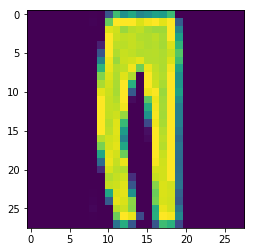

In [24]:
plt.imshow(x_test[2].reshape(28,28))
# generator.predict()

(array([[0.000e+00, 0.000e+00, 5.000e+00, 6.000e+00, 4.000e+00, 1.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 1.400e+01, 3.200e+01, 3.300e+01, 3.500e+01,
         1.500e+01, 2.000e+00, 2.000e+00, 0.000e+00],
        [0.000e+00, 7.000e+00, 4.300e+01, 2.190e+02, 4.300e+02, 4.600e+02,
         1.120e+02, 1.800e+01, 5.000e+00, 0.000e+00],
        [0.000e+00, 5.000e+00, 8.800e+01, 4.680e+02, 1.324e+03, 9.590e+02,
         1.490e+02, 2.600e+01, 1.400e+01, 0.000e+00],
        [5.000e+00, 1.300e+01, 9.700e+01, 4.830e+02, 2.044e+03, 1.118e+03,
         1.660e+02, 6.500e+01, 2.100e+01, 3.000e+00],
        [0.000e+00, 8.000e+00, 4.400e+01, 1.270e+02, 3.820e+02, 3.160e+02,
         1.410e+02, 8.600e+01, 1.500e+01, 2.000e+00],
        [0.000e+00, 3.000e+00, 8.000e+00, 1.900e+01, 7.800e+01, 7.500e+01,
         5.900e+01, 4.000e+01, 7.000e+00, 0.000e+00],
        [1.000e+00, 2.000e+00, 1.000e+00, 7.000e+00, 2.100e+01, 1.300e+01,
         1.300e+01, 1.

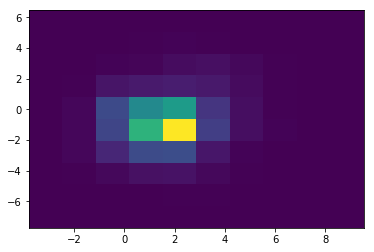

In [25]:
plt.hist2d(x_test_encoded[:,0],x_test_encoded[:,1])

In [26]:
cat_vec = np.concatenate([x_test_encoded[:5],y_oh_enc[:5]],axis=1)
cat_vec.shape

(5, 12)

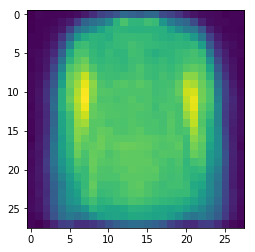

In [32]:
# x_test_encoded[2]
dec_test = generator.predict(cat_vec)
plt.imshow(dec_test[4].reshape(28,28))

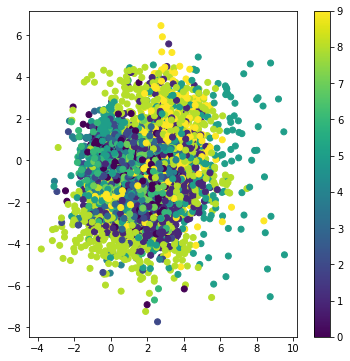

In [33]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [34]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1002      
Total params: 644,002
Trainable params: 644,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from datetime import date
print(date.today())
save_dir = '/home/elijahc/projects/vae/models/'+str(date.today())+'/'


In [ ]:
# vae.save(save_dir+'vae_3layer.h5',include_optimizer=False)
# encoder.save(save_dir+'enc.h5',include_optimizer=False)

In [56]:
def sweep_lat(z,y_class,sweep=0,hold=1,num_std=2):
    z_mean = z[:,sweep].mean()
    z_std = z[:,sweep].std()
    x0 = np.array([z_mean-(num_std*z_std),z[:,hold].mean()])
    x1 = np.array([z_mean+(num_std*z_std),z[:,hold].mean()])
    traj = gen_trajectory(np.concatenate([x0,y_class],axis=0),np.concatenate([x1,y_class],axis=0),delta=.1)
    return traj

In [57]:
# z0_mean = np.mean(x_test_encoded[:,0])
# z0_std = x_test_encoded[:,0].std()
# z1_mean = x_test_encoded[:,1].mean()
# z1_std = x_test_encoded[:,1].std()
# x0 = np.array([z0_mean-(2*z0_std),z1_mean])
# x1 = np.array([z0_mean+(2*z0_std),z1_mean])


In [58]:
traj.shape

(11, 12)

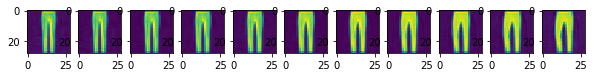

In [66]:
traj = sweep_lat(x_test_encoded,y_oh_enc[5])
dec_traj = K.get_value(generator(K.variable(traj)))
dec_traj = dec_traj.reshape(11,28,28)
fig, axs = plt.subplots(1,11,figsize=(10,10))
for i,ax in enumerate(axs):
    
    ax.imshow(dec_traj[i])

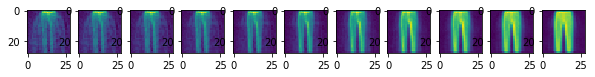

In [65]:
traj = sweep_lat(x_test_encoded,y_oh_enc[5],sweep=1,hold=0)
dec_traj = K.get_value(generator(K.variable(traj)))
dec_traj = dec_traj.reshape(11,28,28)
fig, axs = plt.subplots(1,11,figsize=(10,10))
for i,ax in enumerate(axs):
    
    ax.imshow(dec_traj[i])

In [ ]:
fig, axs = plt.subplots(1,11,figsize=(10,10))
for i,ax in enumerate(axs):
    
    ax.imshow(dec_traj[i])

In [ ]:
enc_32 = vae.layers[6]
enc_256 = vae.layers[7]

In [ ]:
encoder.trainable=False
x = enc_32(encoder.outputs[0])
y_class_oh = Dense(10,activation='softmax')(x)

In [ ]:
med = Model(inputs=inputs,outputs=y_class_oh)
med.layers[-2].trainable=False
for l in med.layers[1:4]:
    l.trainable=False
med.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
y_train_oh = to_categorical(y_train,num_classes=10)

In [ ]:
y_train_oh.shape

In [ ]:
med.summary()

In [ ]:
med.fit(x_train,y_train_oh,
        batch_size=128,
        epochs=25,
        validation_data=(x_test,to_categorical(y_test,num_classes=10))
       )

In [ ]:
x_g = generator.predict(x_test_encoded[:3])
y_test_im = x_g.reshape(3,28,28)

In [ ]:
x_test_im = x_test.reshape(10000,28,28)[:3]

fig,axs = plt.subplots(1,3)
for im,ax in zip(x_test_im,axs):
    ax.imshow(im)

In [ ]:
fig,axs = plt.subplots(1,3)
for im,ax in zip(y_test_im,axs):
    ax.imshow(im)

In [ ]:
med.evaluate(x_test,to_categorical(y_test,num_classes=10))